# Main Project 2 - U-Net을 이용한 이미지 세그멘테이션

In [1]:
import os
import random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, Input, Model

import warnings 
warnings.filterwarnings(action='ignore')

### (1) 실습환경 준비

In [ ]:
%pip install datasets
%pip install huggingface_hub

In [36]:
import datasets
from datasets import load_dataset

train_dataset, val_dataset = load_dataset("nateraw/pascal-voc-2012", split=['train', 'val'])
dataset = pd.DataFrame(train_dataset)
dataset

,image,mask
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...
1459,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1460,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1461,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1462,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...


### (2) 데이터 전처리

In [55]:
from PIL import Image

dataset['reimage'] = None
dataset['remask'] = None

# (572, 572)로 크기 조절
for i in range(len(dataset)):
    dataset['reimage'][i] = np.array(dataset['image'][i].resize((572, 572)))
    dataset['remask'][i] = np.array(dataset['mask'][i].resize((572, 572)))

# 결측치 확인
dataset.isnull().sum()

image      0
mask       0
reimage    0
remask     0
dtype: int64

In [59]:
# data check
print(np.shape(dataset['reimage'][0]))
print(np.shape(dataset['remask'][0]))

(572, 572, 3)
(572, 572, 3)


### (3) Segmentation map 만들기

In [60]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [61]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

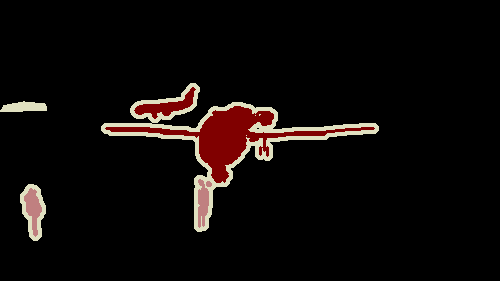

In [76]:
dataset['mask'][0]

In [81]:
type(dataset['remask'][0][250, 250])

numpy.ndarray

In [82]:
colormap = colormap[:21]

dataset['segmap'] = None

for d in dataset['remask']:
    segimg = np.zeros(d.shape, dtype=int)

    for r in range(len(d)):
        for c in range(len(d)):
            for s in colormap:
                print(type(s))
                if d[r, c] - s == [0, 0, 0]:
                    segimg[r, c] = c.index(s)

<class 'numpy.ndarray'>


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [47]:
# train, test set split
train_size = math.floor(len(dataset) * 0.8)
train_image = dataset['reimage'][:train_size]
train_label = dataset['remask'][:train_size]
test_image = dataset['reimage'][train_size:]
test_label = dataset['remask'][train_size:]

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())